In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the dataset directory
dataset_dir = '/content/drive/MyDrive/Malaria'

# Check if the dataset directory exists
if not os.path.exists(dataset_dir):
    print("Dataset directory does not exist.")
else:
    print("Dataset directory exists.")

# Main classification (Infected vs. Not Infected)
main_classes = ['Infected', 'Not Infected']
num_main_classes = len(main_classes)

# Build the main model
base_model_main = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model_main.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions_main = Dense(num_main_classes, activation='softmax')(x)
model_main = Model(inputs=base_model_main.input, outputs=predictions_main)

# Freeze the base model layers
for layer in base_model_main.layers:
    layer.trainable = False

# Compile the main model
model_main.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data augmentation and generators for the main classification
train_datagen_main = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)

train_generator_main = train_datagen_main.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator_main = train_datagen_main.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Set up callbacks for training
early_stopping_main = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_main = ModelCheckpoint('best_model_xception_main.keras', save_best_only=True, monitor='val_loss')
reduce_lr_main = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the main model
history_main = model_main.fit(
    train_generator_main,
    validation_data=validation_generator_main,
    epochs=10,
    callbacks=[early_stopping_main, model_checkpoint_main, reduce_lr_main]
)

# Evaluate the main model and generate confusion matrix
val_steps_main = validation_generator_main.samples // validation_generator_main.batch_size
predictions_main = model_main.predict(validation_generator_main, steps=val_steps_main + 1)  # Added +1 for remainder
predicted_classes_main = np.argmax(predictions_main, axis=1)

# Get true labels for main classification
true_classes_main = validation_generator_main.classes

# Confusion matrix for main classification (Infected vs. Not Infected)
cm_main = confusion_matrix(true_classes_main, predicted_classes_main)
disp_main = ConfusionMatrixDisplay(confusion_matrix=cm_main, display_labels=main_classes)
disp_main.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Main Classification (Infected vs. Not Infected)")
plt.show()

# Proceed with stage classification (types of Infected malaria)
infected_dir = os.path.join(dataset_dir, 'infected')
stage_classes = os.listdir(infected_dir)
num_stage_classes = len(stage_classes)

# Build the stage classification model
base_model_stage = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x_stage = base_model_stage.output
x_stage = GlobalAveragePooling2D()(x_stage)
x_stage = Dense(128, activation='relu')(x_stage)
predictions_stage = Dense(num_stage_classes, activation='softmax')(x_stage)  # Final layer for stage classification
model_stage = Model(inputs=base_model_stage.input, outputs=predictions_stage)

# Freeze the base model layers for stage classification
for layer in base_model_stage.layers:
    layer.trainable = False

# Compile the stage model
model_stage.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data augmentation and generators for the stage classification
train_datagen_stage = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)

train_generator_stage = train_datagen_stage.flow_from_directory(
    infected_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator_stage = train_datagen_stage.flow_from_directory(
    infected_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Set up callbacks for stage training
early_stopping_stage = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_stage = ModelCheckpoint('best_model_xception_stage.keras', save_best_only=True, monitor='val_loss')
reduce_lr_stage = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the stage model
history_stage = model_stage.fit(
    train_generator_stage,
    validation_data=validation_generator_stage,
    epochs=10,
    callbacks=[early_stopping_stage, model_checkpoint_stage, reduce_lr_stage]
)

# Evaluate the stage model and generate confusion matrix
val_steps_stage = validation_generator_stage.samples // validation_generator_stage.batch_size
predictions_stage = model_stage.predict(validation_generator_stage, steps=val_steps_stage + 1)  # Added +1 for remainder
predicted_classes_stage = np.argmax(predictions_stage, axis=1)

# Get true labels for stage classification
true_classes_stage = validation_generator_stage.classes

# Confusion matrix for stage classification (malaria types)
cm_stage = confusion_matrix(true_classes_stage, predicted_classes_stage)
disp_stage = ConfusionMatrixDisplay(confusion_matrix=cm_stage, display_labels=stage_classes)
disp_stage.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Stage Classification (Malaria Types)")
plt.show()

# Evaluate the main model (Infected vs. Not Infected)
loss_main, accuracy_main = model_main.evaluate(validation_generator_main)
print(f"Main Validation Loss: {loss_main}, Main Validation Accuracy: {accuracy_main}")

# Evaluate the stage model (malaria types)
loss_stage, accuracy_stage = model_stage.evaluate(validation_generator_stage)
print(f"Stage Validation Loss: {loss_stage}, Stage Validation Accuracy: {accuracy_stage}")


Dataset directory exists.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3033 images belonging to 2 classes.
Found 757 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 1312s 13s/step - accuracy: 0.9512 - loss: 0.1036 - val_accuracy: 0.9934 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1098s 11s/step - accuracy: 0.9911 - loss: 0.0185 - val_accuracy: 0.9855 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1093s 11s/step - accuracy: 0.9967 - loss: 0.0106 - val_accuracy: 0.9974 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 4/10
 2/95 ━━━━━━━━━━━━━━━━━━━━ 12:48 8s/step - accuracy: 1.0000 - loss: 3.1317e-04 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


18/18 [==============================] - 30s 2s/step - loss: 0.1832 - accuracy: 0.9322
Stage Validation Loss: 0.18318428099155426, Stage Validation Accuracy: 0.9322344064712524
1/1 [==============================] - 0s 73ms/step


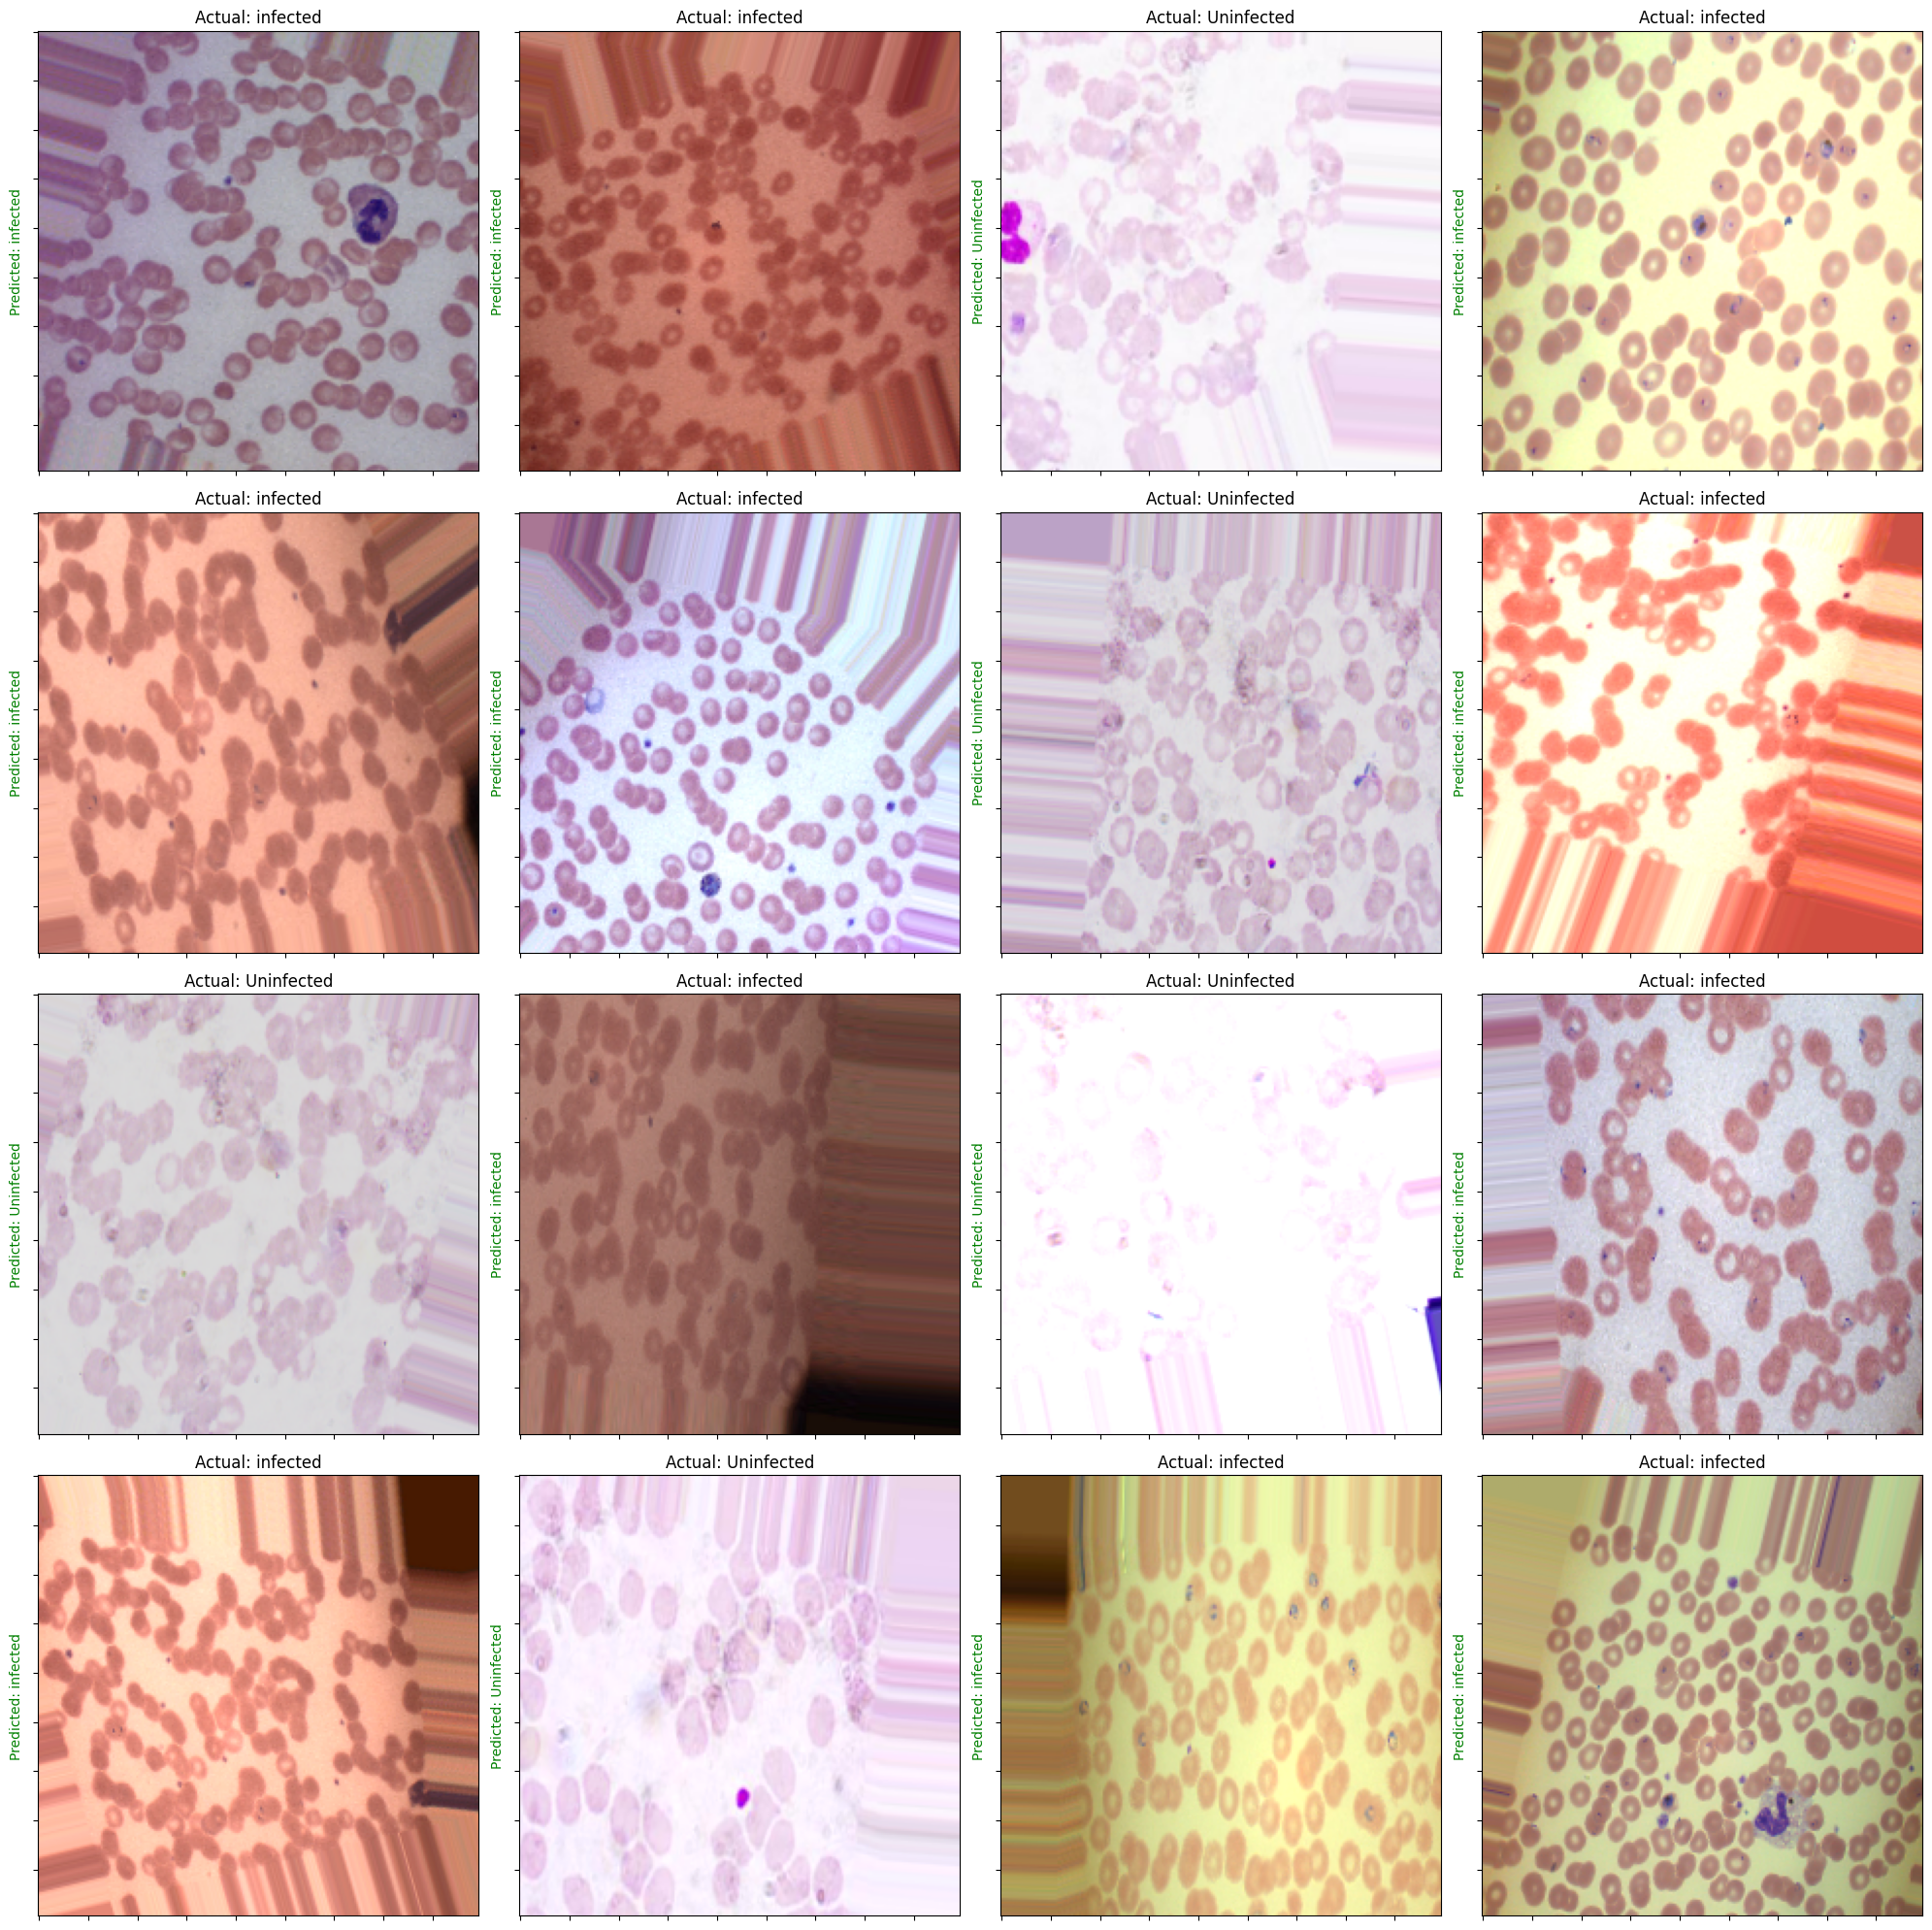

In [ ]:
loss_stage, accuracy_stage = model_stage.evaluate(validation_generator_stage)
print(f"Stage Validation Loss: {loss_stage}, Stage Validation Accuracy: {accuracy_stage}")

# Visualization of predictions for main classification
plt.figure(figsize=(20, 20))
class_names_main = train_generator_main.class_indices  # Get main class indices
class_names_main = {v: k for k, v in class_names_main.items()}  # Reverse the dictionary

# Take one batch of validation data for main classification
images_main, labels_main = next(validation_generator_main)  # Get one batch

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images_main[i])  # No need to convert to uint8 as they are already scaled
    predictions_main = model_main.predict(tf.expand_dims(images_main[i], axis=0))

    score_main = tf.nn.softmax(predictions_main[0])
    predicted_class_main = class_names_main[np.argmax(score_main)]
    actual_class_main = class_names_main[np.argmax(labels_main[i])]

    plt.title(f"Actual: {actual_class_main}")

    if actual_class_main == predicted_class_main:
        plt.ylabel(f"Predicted: {predicted_class_main}", fontdict={'color': 'green'})
    else:
        plt.ylabel(f"Predicted: {predicted_class_main}", fontdict={'color': 'red'})

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 75ms/step


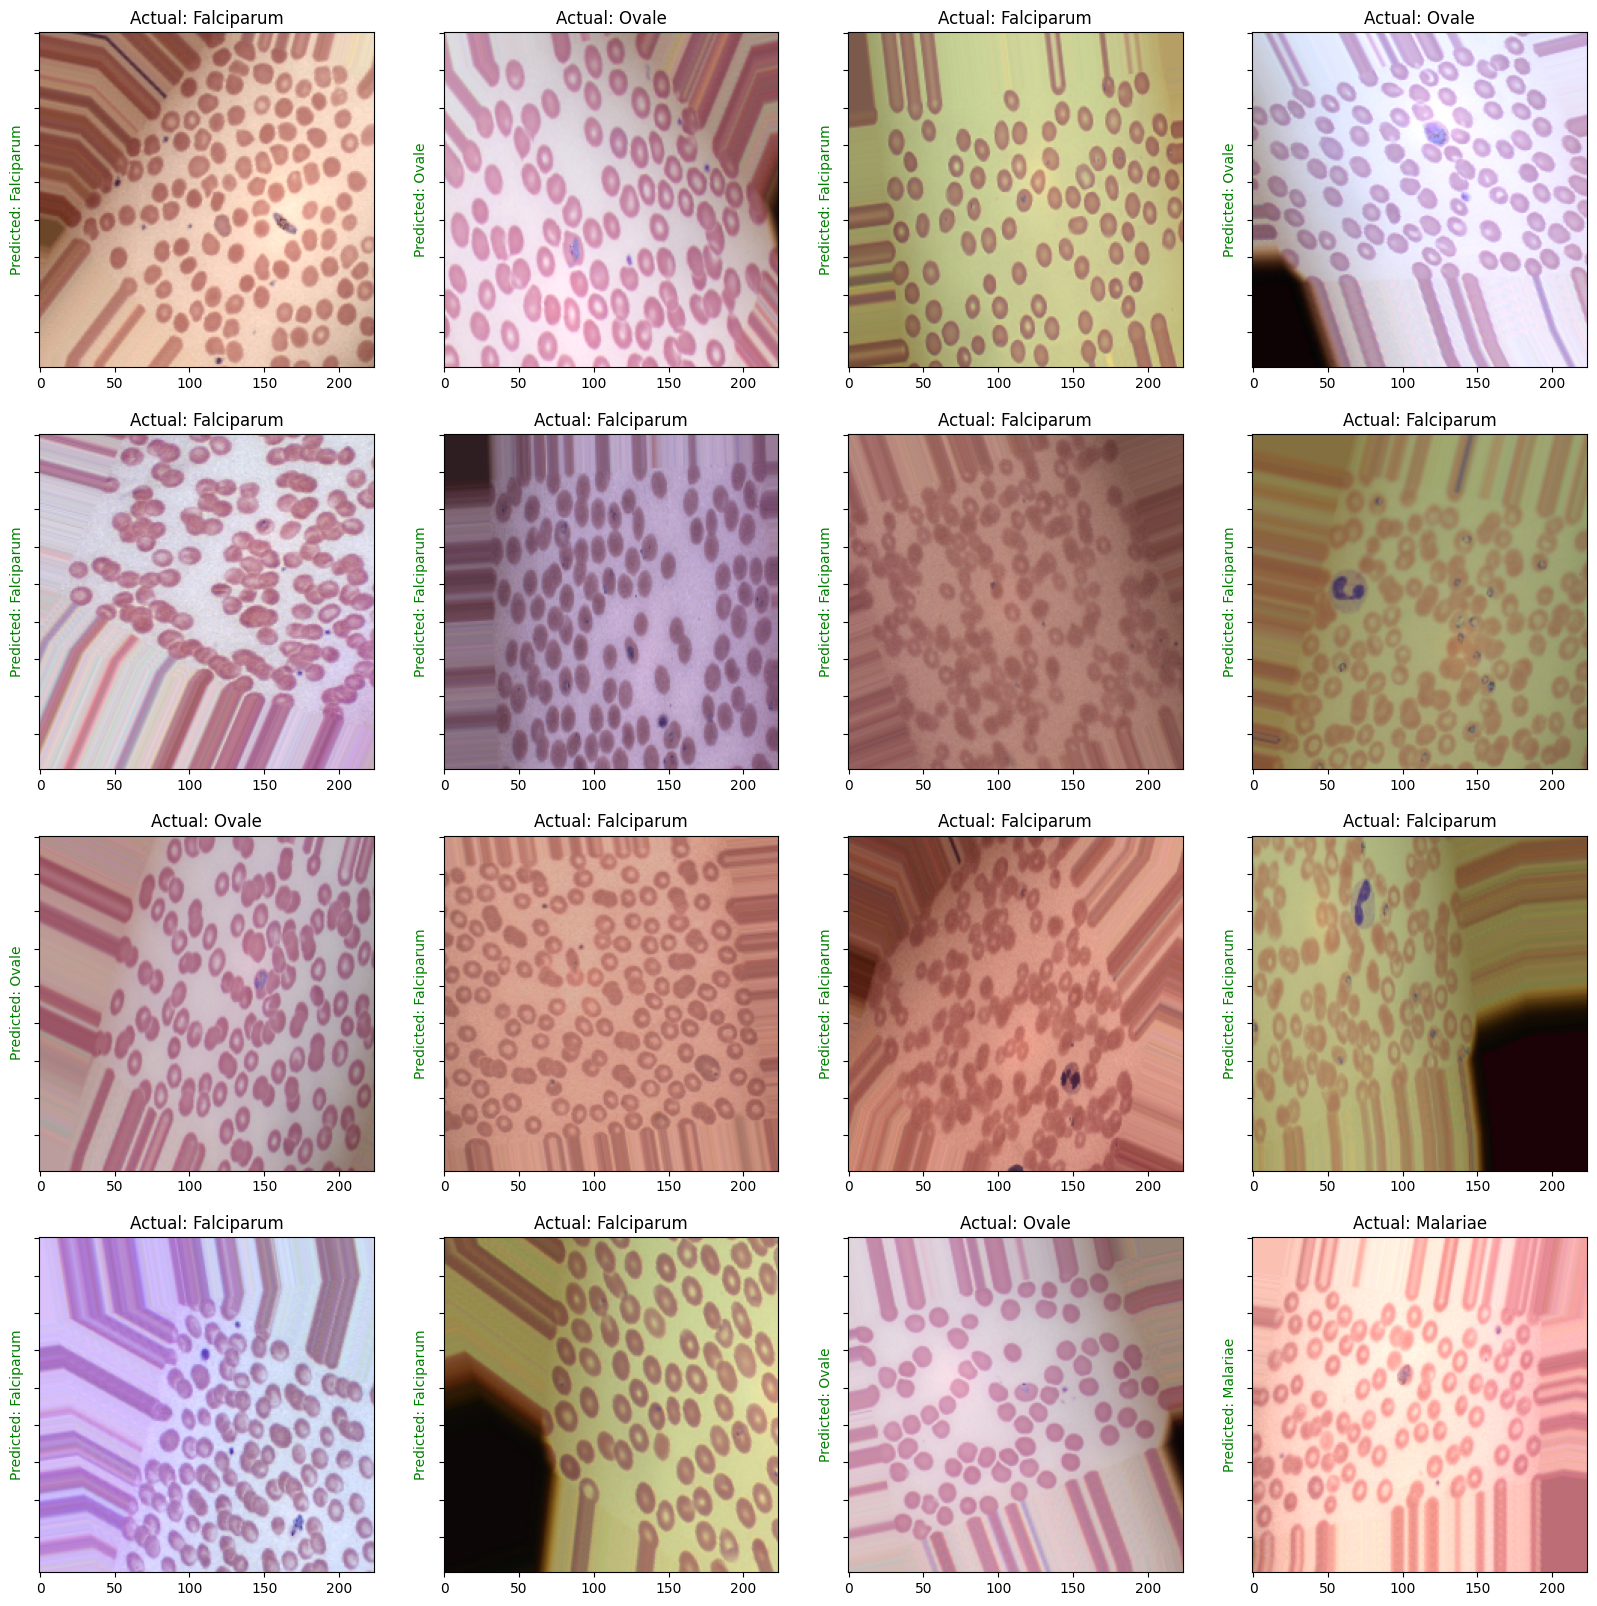

In [ ]:
# Visualization of predictions for stage classification
plt.figure(figsize=(20, 20))
class_names_stage = train_generator_stage.class_indices  # Get stage class indices
class_names_stage = {v: k for k, v in class_names_stage.items()}  # Reverse the dictionary

# Take one batch of validation data for stage classification
images_stage, labels_stage = next(validation_generator_stage)  # Get one batch

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images_stage[i])  # No need to convert to uint8 as they are already scaled
    predictions_stage = model_stage.predict(tf.expand_dims(images_stage[i], axis=0))

    score_stage = tf.nn.softmax(predictions_stage[0])
    predicted_class_stage = class_names_stage[np.argmax(score_stage)]
    actual_class_stage = class_names_stage[np.argmax(labels_stage[i])]

    plt.title(f"Actual: {actual_class_stage}")

    if actual_class_stage == predicted_class_stage:
        plt.ylabel(f"Predicted: {predicted_class_stage}", fontdict={'color': 'green'})
    else:
        plt.ylabel(f"Predicted: {predicted_class_stage}", fontdict={'color': 'red'})

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels


In [ ]:
import pandas as pd
hist=pd.DataFrame(history_stage.history)
hist

loss  accuracy  val_loss  val_accuracy     lr
0  0.677713  0.747378  0.450727      0.835165  0.001
1  0.392019  0.858641  0.345112      0.866300  0.001
2  0.344682  0.868217  0.290615      0.906593  0.001
3  0.275112  0.893297  0.275003      0.906593  0.001
4  0.262329  0.896489  0.252105      0.910256  0.001
5  0.257173  0.899225  0.238476      0.912088  0.001
6  0.237549  0.909713  0.189564      0.924908  0.001
7  0.235984  0.912905  0.223120      0.921245  0.001
8  0.215687  0.917465  0.203499      0.924908  0.001
9  0.186947  0.927953  0.219021      0.913919  0.001

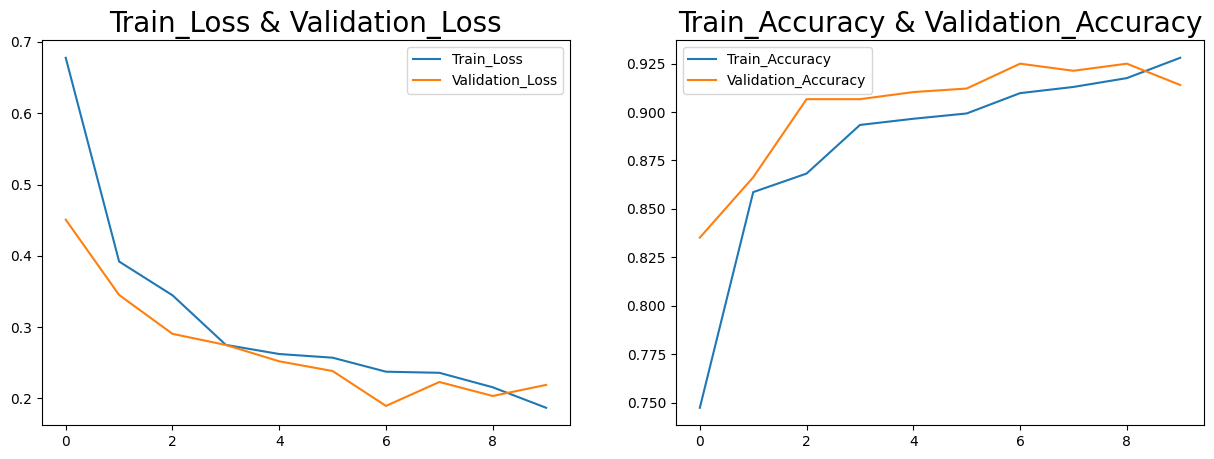

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist['loss'],label='Train_Loss')
plt.plot(hist['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['accuracy'],label='Train_Accuracy')
plt.plot(hist['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
import pandas as pd
hist1=pd.DataFrame(history_main.history)
hist1

loss  accuracy  val_loss  val_accuracy      lr
0  0.062109  0.973953  0.018560      0.996037  0.0010
1  0.009576  0.997033  0.041684      0.988111  0.0010
2  0.012057  0.995714  0.015450      0.993395  0.0010
3  0.006590  0.997692  0.002859      1.000000  0.0010
4  0.011250  0.996044  0.017192      0.990753  0.0010
5  0.014841  0.994725  0.019778      0.993395  0.0010
6  0.004831  0.998351  0.003023      0.998679  0.0010
7  0.005001  0.998022  0.002463      1.000000  0.0002
8  0.003417  0.998681  0.004892      0.998679  0.0002
9  0.002943  0.999011  0.001236      1.000000  0.0002

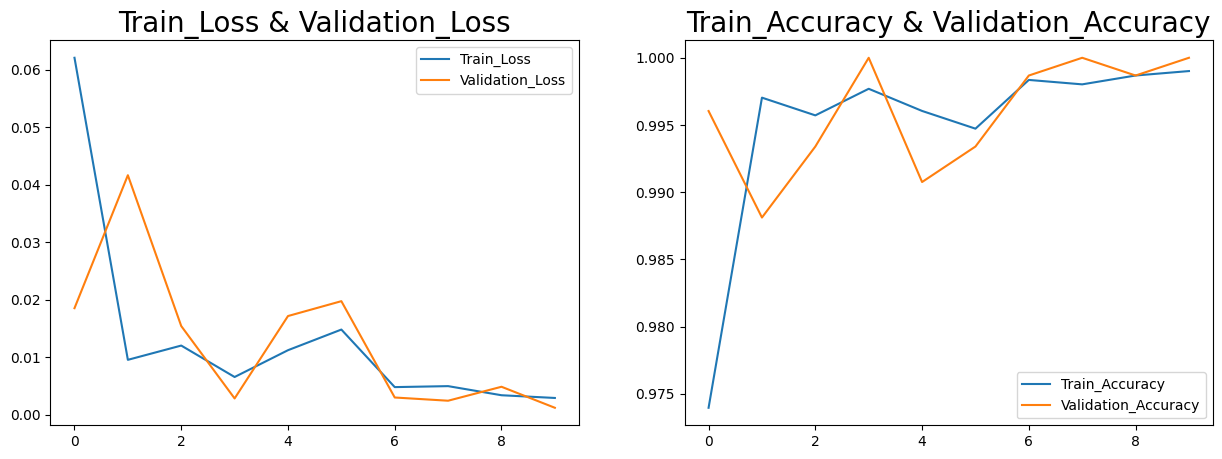

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist1['loss'],label='Train_Loss')
plt.plot(hist1['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist1['accuracy'],label='Train_Accuracy')
plt.plot(hist1['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have true_classes_stage and predicted_classes_stage
print(classification_report(true_classes_stage, predicted_classes_stage, target_names=stage_classes))



              precision    recall  f1-score   support

       Vivax       0.42      0.45      0.43       238
       Ovale       0.10      0.07      0.08        87
    Malariae       0.21      0.23      0.22       128
  Falciparum       0.19      0.18      0.19        93

    accuracy                           0.29       546
   macro avg       0.23      0.23      0.23       546
weighted avg       0.28      0.29      0.29       546



In [ ]:
model_main.save('best_model_xception_main.keras')
model_stage.save('best_model_xception_stage.keras')